<a href="https://colab.research.google.com/github/CDAC-lab/ETFA-Workshop/blob/main/CNN_and_LSTM_for_Human_Activity_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Building a sequntial classifier (Time series classfication)

In this workshop we will be using LSTM and CNN models for a time series classification task. The dataset that we will be using is the 
[Human Activity Recognition Using Smartphones Data set](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones). It was prepared by Davide Anguita, et al. from the University of Genova, Italy and is described in full in their 2013 paper “[A Public Domain Dataset for Human Activity Recognition Using Smartphones](https://upcommons.upc.edu/handle/2117/20897)”.
 This was made available and can be downloaded for free from the UCI Machine Learning Repository.

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities,

1.   WALKING
2.   WALKING_UPSTAIRS
3.   WALKING_DOWNSTAIRS
4.   SITTING
5.   STANDING
6.   LAYING

wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope, they captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain.

A video of the experiment including an example of the 6 recorded activities with one of the participants can be seen in the following [link](https://www.youtube.com/watch?v=XOEN9W05_4A&ab_channel=JorgeLuisReyesOrtiz).

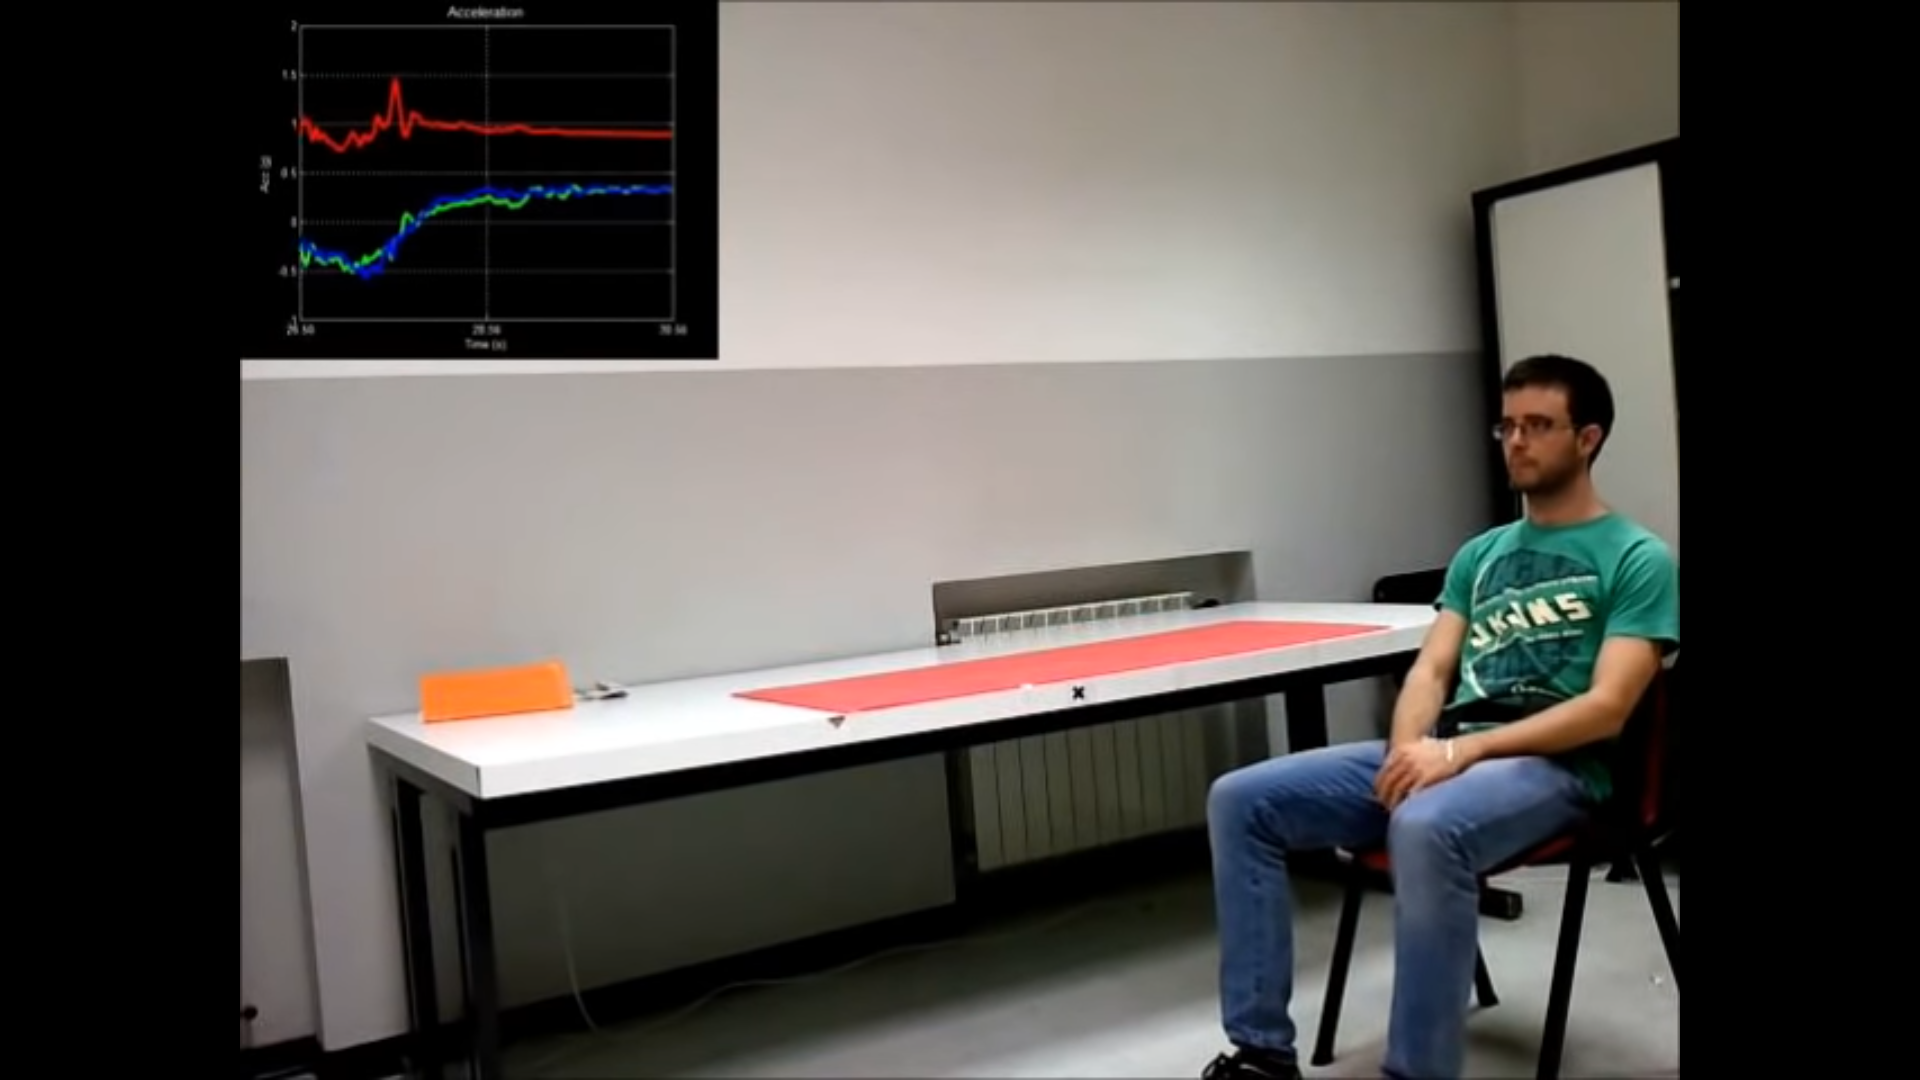

##Importing the libraries

Load required libraries for modeling and data processing

In [ ]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import keras
import zipfile
# set seed to reproduce similar results
np.random.seed(0)

Libraries to load data from google drive shared location.

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Authenticate and create the python document (PyDrive) client.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

When prompted, click on the link to get authentication to allow Google to access your Drive. You should see a screen with “Google Cloud SDK wants to access your Google Account” at the top. After you allow permission, copy the given verification code and paste it in the box in Colab.

In [ ]:

dataset_file_id = '1xnD6OXIMNOChR4V9DKO-Jjsb7QNMUjc0'


Download the dataset file.

In [ ]:
downloaded = drive.CreateFile({'id':dataset_file_id}) 
downloaded.GetContentFile('UCI HAR Dataset.zip')

Unzip the data to the same directory

In [ ]:
!unzip "/content/UCI HAR Dataset.zip" -d "/content/"

Archive:  /content/UCI HAR Dataset.zip
   creating: /content/UCI HAR Dataset/
  inflating: /content/UCI HAR Dataset/.DS_Store  
   creating: /content/__MACOSX/
   creating: /content/__MACOSX/UCI HAR Dataset/
  inflating: /content/__MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: /content/UCI HAR Dataset/activity_labels.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: /content/UCI HAR Dataset/features.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features.txt  
  inflating: /content/UCI HAR Dataset/features_info.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._features_info.txt  
  inflating: /content/UCI HAR Dataset/README.txt  
  inflating: /content/__MACOSX/UCI HAR Dataset/._README.txt  
   creating: /content/UCI HAR Dataset/test/
   creating: /content/UCI HAR Dataset/test/Inertial Signals/
  inflating: /content/UCI HAR Dataset/test/Inertial Signals/body_acc_x_test.txt  
   creating: /content/__MACOSX/UCI HAR Dataset/test/
   

Helper functions to load and split train and test data

In [ ]:
# load a single file as a numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y

# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + 'UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + 'UCI HAR Dataset/')
    # zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    # one hot encode y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    print("trainX shape: ",trainX.shape)
    print("trainy shape: ", trainy.shape)
    print("testX shape: ", testX.shape)
    print("testy shape: ", testy.shape)
    return trainX, trainy, testX, testy

For training data we have 7352 different samples, where one sample is one window of the time series data, each window has 128 time steps, and a time step has nine variables or features.

Similarly for testing data we have 2947 different samples. 

In [ ]:
trainX, trainy, testX, testy = load_dataset()

trainX shape:  (7352, 128, 9)
trainy shape:  (7352, 6)
testX shape:  (2947, 128, 9)
testy shape:  (2947, 6)


## Explore the data

In this dataset we have the following 9 features:


1.   Total Acceleration x
2.   Total Acceleration y
3.   Total Acceleration z
4.   Body Acceleration x
5.   Body Acceleration y
6.   Body Acceleration z
7.   Body Gyroscope x
8.   Body Gyroscope y
9.   Body Gyroscope z



In [ ]:
# Helper function to plot distribution of the features
def plot_distributions(trainX):
	# remove overlap
	cut = int(trainX.shape[1] / 2)
	longX = trainX[:, -cut:, :]
	# flatten windows
	longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
	print(longX.shape)
	pyplot.figure()
	xaxis = None
	for i in range(longX.shape[1]):
		ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
		ax.set_xlim(-1, 1)
		if i == 0:
			xaxis = ax
		pyplot.hist(longX[:, i], bins=100)
	pyplot.show()

(470528, 9)


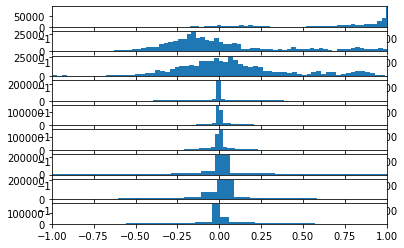

In [ ]:
# plot distributions
plot_distributions(trainX)

We can see that all variables except "Total Acceleration x" behave like normal distributions. 

## Building the models

In this workshop, we will develop 2 deep learning models and evaluate the classification accuracy.



1.   LSTM model
2.   CNN model



Set common parameters across all the models

In [ ]:
## set number of epochs and batch size
train_epochs = 15
batch_size = 64
validation_split = 0.2

### LSTM model

Model design:

The model is defined as a Sequential Keras model.

The first layer of the model is set to a single LSTM hidden layer. This is followed by a dropout layer which is to reduce overfitting of the model to the training data. Finally, a dense fully connected layer is used to interpret the features extracted by the LSTM hidden layer, at last we have the final softmax layer which represent the 6 classes. 

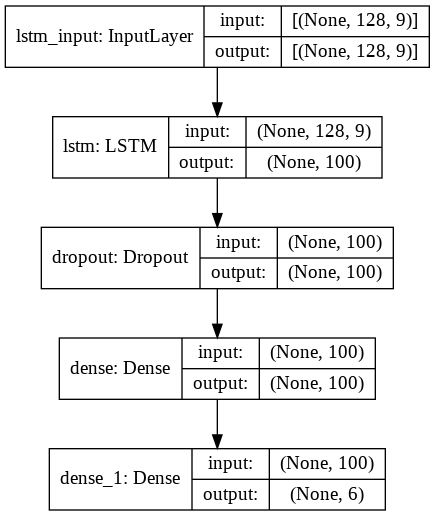

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Train the model

In [ ]:
# fit network
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/15
92/92 [==============================] - 15s 140ms/step - loss: 1.2473 - accuracy: 0.4622 - val_loss: 0.9493 - val_accuracy: 0.6438
Epoch 2/15
92/92 [==============================] - 13s 137ms/step - loss: 0.7823 - accuracy: 0.6596 - val_loss: 0.8165 - val_accuracy: 0.7124
Epoch 3/15
92/92 [==============================] - 12s 135ms/step - loss: 0.6540 - accuracy: 0.7155 - val_loss: 0.8221 - val_accuracy: 0.7267
Epoch 4/15
92/92 [==============================] - 12s 135ms/step - loss: 0.5159 - accuracy: 0.8000 - val_loss: 0.7050 - val_accuracy: 0.7138
Epoch 5/15
92/92 [==============================] - 13s 136ms/step - loss: 0.4589 - accuracy: 0.8363 - val_loss: 0.6132 - val_accuracy: 0.8402
Epoch 6/15
92/92 [==============================] - 13s 137ms/step - loss: 0.3336 - accuracy: 0.8859 - val_loss: 0.5231 - val_accuracy: 0.8538
Epoch 7/15
92/92 [==============================] - 12s 134ms/step - loss: 0.2530 - accuracy: 0.9167 - val_loss: 0.4638 - val_accuracy: 0.8783

Visualize the training process (loss) w.r.t train set and the validation set

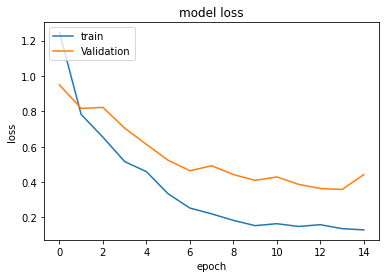

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the LSTM model", test_accuracy)

Accuracy of the LSTM model 0.8951476216316223


### CNN model

Model design:

We will define the model as having two 1D CNN layers (each with 64 filters of kernel size 4), followed by a dropout layer to avoid overfiting for training set, then a pooling layer before flattening and connecting to the fully connected layer. At last we have the final softmax layer which represent the 6 classes similar to the LSTM model.

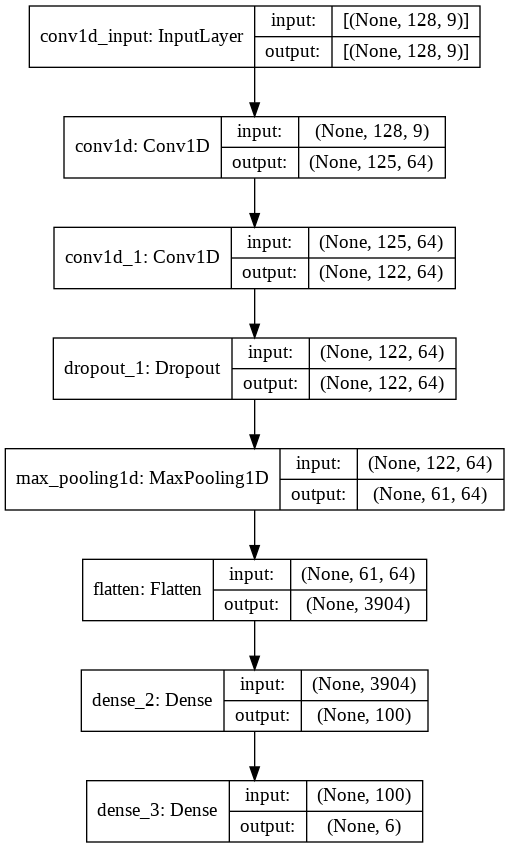

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))
plot_model(model, show_shapes=True, show_layer_names=True)

Compile the model with [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function and [ADAM optimizer](https://keras.io/api/optimizers/).

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Train the model

In [ ]:
# fit network
history = model.fit(trainX, trainy, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_split=validation_split, shuffle=True)

Epoch 1/15
92/92 [==============================] - 5s 51ms/step - loss: 0.5365 - accuracy: 0.7876 - val_loss: 0.4153 - val_accuracy: 0.8729
Epoch 2/15
92/92 [==============================] - 5s 51ms/step - loss: 0.1618 - accuracy: 0.9381 - val_loss: 0.3447 - val_accuracy: 0.9021
Epoch 3/15
92/92 [==============================] - 4s 49ms/step - loss: 0.1106 - accuracy: 0.9568 - val_loss: 0.3688 - val_accuracy: 0.9028
Epoch 4/15
92/92 [==============================] - 5s 49ms/step - loss: 0.0949 - accuracy: 0.9597 - val_loss: 0.3821 - val_accuracy: 0.9062
Epoch 5/15
92/92 [==============================] - 4s 48ms/step - loss: 0.1049 - accuracy: 0.9572 - val_loss: 0.4649 - val_accuracy: 0.9157
Epoch 6/15
92/92 [==============================] - 4s 47ms/step - loss: 0.0856 - accuracy: 0.9602 - val_loss: 0.4803 - val_accuracy: 0.9137
Epoch 7/15
92/92 [==============================] - 5s 49ms/step - loss: 0.0800 - accuracy: 0.9623 - val_loss: 0.5421 - val_accuracy: 0.9123
Epoch 8/15
92

Visualize the training process (loss) w.r.t train set and the validation set

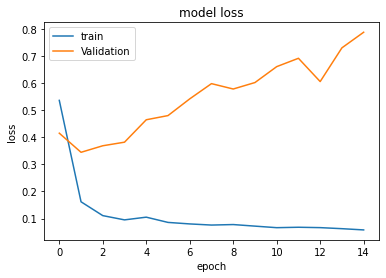

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

Evaluate the LSTM model

In [ ]:
# evaluate model
test_loss, test_accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
print("Accuracy of the CNN model", test_accuracy)

Accuracy of the CNN model 0.8931116461753845
